Implementing COVID-19  face mask detector training script with Keras and TensorFlow

```
# import the necessary packages
```

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Retrieve the datasets


In [ ]:
dataset =r'/content/drive/MyDrive/dataset'
imagePaths=list(paths.list_images(dataset))

In [ ]:
imagePaths

['/content/drive/MyDrive/dataset/without_mask/1.jpg',
 '/content/drive/MyDrive/dataset/without_mask/10.jpg',
 '/content/drive/MyDrive/dataset/without_mask/100.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1001.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1003.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1011.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1000.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1006.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1010.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1004.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1014.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1002.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1008.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1013.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1005.jpg',
 '/content/drive/MyDrive/dataset/without_mask/101.jpg',
 '/content/drive/MyDrive/dataset/without_mask/1009.jpg',
 '/content/drive/MyDrive/dataset/witho

The training data are loaded and pre-processed.

Based on the implementation, we are:

*  Grabbing all of the imagePaths in the dataset 
*  Initializing data and labels lists
*  Looping over the imagePaths and loading + pre-processing images . 
*  The preprocessing steps include resizing to 224x224 pixels, conversion to array format, and scaling the pixel intensities in the input image to the range [-1,1] (via the preprocess_input convenience function).
*  Appending the pre-processed image and associated label to data and labels list, respectively 
*  Ensuring the training data is in NumPy array format (Line 63-64)



In [ ]:
data = []
labels = []

for i in imagePaths:
  label=i.split(os.path.sep)[-2]
  labels.append(label)
  image=load_img(i,target_size=(224,224))
  image=img_to_array(image)
  image=preprocess_input(image)
  data.append(image)

In [ ]:
data

[array([[[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        ...,
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.     

In [ ]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [ ]:
data.shape

(1680, 224, 224, 3)

In [ ]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

Encoding the labels, partition the datasets.
For Data Augmentation:

In [ ]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [ ]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [ ]:
train_X.shape

(1344, 224, 224, 3)

In [ ]:
train_Y.shape

(1344, 2)

In [ ]:
test_X.shape

(336, 224, 224, 3)

In [ ]:
test_Y.shape

(336, 2)

Using scikit-learn's convenience method, we segments the data into:
* 80% training
* 20% testing

In data augmentation, we apply on-the-fly mutations to the images, where the random rotation, zoom, shear, shift, and flip parameters are established to improve generalization.

The *aug* object is used at training time

In [ ]:
aug=ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15, 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest'
  )

**Preparing MobileNetV2 for fine-tuning:**

Fine-tuning setup is a three-step process:
*  Load MobileNet with pre-trained ImageNet weights, leaving off head of networks 
*  Construct a new FC head, and append it to the base in place of the old head 
*  Freeze the base layers of the network. The weights of these base layers will not be updated during the process of backpropagation, whereas the head layer weights will be tuned.



In [ ]:
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128, activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2, activation='softmax')(headModel)

model=Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
  layer.trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Then, the face mask detector network is ready to compile and trained. 

The data augmentation (aug) will be providing batches of mutated image data. 

Once training is complete, the resulting model is evaluated on the test set, by making predictions, grabbing the highest probability class label indices, and printing a classification report in the terminal for inspection. 

 In addition, the face mask classification model is serialized to disk. 
 
 The last step is to plot the accuracy and loss curves.


In [ ]:
INIT_LR=1e-4
EPOCHS=20
BS=32

opt=Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X, train_Y, batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X, test_Y),
    validation_steps=len(test_X)//BS,
    epochs=EPOCHS
)

model.save(r'/content/drive/MyDrive/facemask_detector/mobilenet_v2.model')

Epoch 1/20
42/42 [==============================] - 73s 2s/step - loss: 0.1872 - accuracy: 0.9233 - val_loss: 0.1097 - val_accuracy: 0.9583
Epoch 2/20
42/42 [==============================] - 69s 2s/step - loss: 0.1590 - accuracy: 0.9430 - val_loss: 0.0974 - val_accuracy: 0.9583
Epoch 3/20
42/42 [==============================] - 68s 2s/step - loss: 0.1709 - accuracy: 0.9404 - val_loss: 0.1100 - val_accuracy: 0.9583
Epoch 4/20
42/42 [==============================] - 68s 2s/step - loss: 0.1477 - accuracy: 0.9474 - val_loss: 0.1070 - val_accuracy: 0.9583
Epoch 5/20
42/42 [==============================] - 68s 2s/step - loss: 0.1690 - accuracy: 0.9455 - val_loss: 0.0972 - val_accuracy: 0.9583
Epoch 6/20
42/42 [==============================] - 68s 2s/step - loss: 0.1533 - accuracy: 0.9509 - val_loss: 0.0857 - val_accuracy: 0.9673
Epoch 7/20
42/42 [==============================] - 68s 2s/step - loss: 0.1473 - accuracy: 0.9453 - val_loss: 0.0894 - val_accuracy: 0.9613
Epoch 8/20
42/42 [==

In [ ]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict, axis=1)
print(classification_report(test_Y.argmax(axis=1), predict, target_names=lb.classes_))

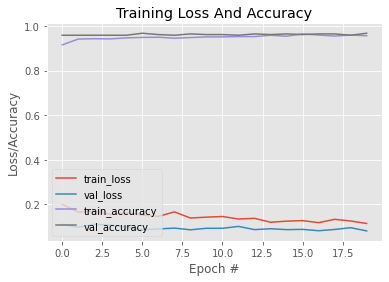

In [ ]:
#plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label = "train_accuracy")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Loss And Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(r'/content/drive/MyDrive/facemask_detectorplot_v2.png')